In [28]:
import numpy as np
import pandas as pd
import cv2
import os
import pydot

In [29]:
img_label_file = "data/labels.csv"

labels_csv = pd.read_csv(img_label_file, index_col=0)
labels = labels_csv.loc["fall-01"]
label_1 = labels.loc[labels["frame"] == 1]
label_1.label

fall name
fall-01   -1
Name: label, dtype: int64

In [30]:
!pip3 install pydot

Defaulting to user installation because normal site-packages is not writeable


In [31]:
### Read in the data
img_data_dir = "data/images/" # replace with your own dir if necessary
img_label_file = "data/labels.csv"

## Given an image name, extracts the label from the labels.csv file. True if 1 False if -1
def extract_label(file_name):
    split = file_name.split("-") # split image name
    fall_name = split[0] + "-" + split[1] # reconstruct fall name
    frame = int(split[-1].split(".")[0]) # end of split is like 113.png. removes .png part
    fall_labels = labels_csv.loc[fall_name]
    frame_label = fall_labels.loc[fall_labels["frame"] == frame]
    return int(frame_label.label) > 0

### Loads in the data from images and stores it in an array. Order is important because 
### The labels are in the same order as the images are appended to the array
def load_img_data():
    imgs = []
    labels = []
    labels_csv = pd.read_csv(img_label_file)
    
    # Iterates through fall folders and the frames within each fall
    for img_folder in os.listdir(img_data_dir):
        path = os.path.join(img_data_dir,img_folder)
        if ("fall" in path and "zip" not in path):
            for file in os.listdir(path):
                img = cv2.imread(os.path.join(path, file))
                img = cv2.resize(img ,(224,224))
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                imgs.append(img)
                labels.append([extract_label(file)])
                
    return imgs, labels

In [32]:
images, labels = load_img_data()

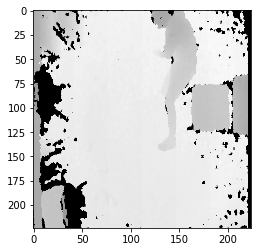

In [33]:
import matplotlib.pyplot as plt
plt.imshow(images[0])

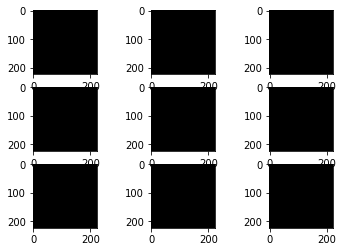

In [34]:
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = images[0]
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [35]:
from sklearn.model_selection import train_test_split
images = np.asarray(images)
labels = np.asarray(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33)


In [36]:
# starter model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [37]:
# transfer learning modifications to the model

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

# model = Sequential()

# pretrained VGG16 model architecture on ImageNet
base_model = VGG16(weights='imagenet', include_top=False)
# model.add(base_model)
x = base_model.output

# x = Flatten()(x)

# add other layers
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid')) 
# for binary; it is model.add(Dense(3, activation='softmax')) for the multi-class version

model = Model(inputs=base_model.input, outputs=x)

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
    if i < 15: # We changed this number to change the number of blocks frozen
        layer.trainable = False

# for layer in base_model.layers:
#     layer.trainable = False

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [38]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(X_train)

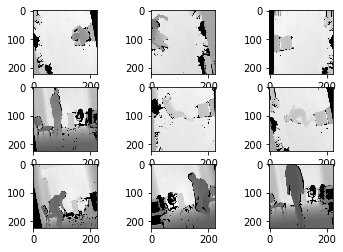

In [40]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=32):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(224, 224, 3))
    # show the plot
    pyplot.show()
    break

In [47]:
model2 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train)/32, epochs=10)

  ...
    to  
  ['...']
Train for 125.40625 steps
Epoch 1/10
126/125 [==============================] - 46s 361ms/step - loss: 0.0497 - accuracy: 0.9843
Epoch 2/10
126/125 [==============================] - 46s 365ms/step - loss: 0.0462 - accuracy: 0.9833
Epoch 3/10
126/125 [==============================] - 46s 369ms/step - loss: 0.0434 - accuracy: 0.9836
Epoch 4/10
126/125 [==============================] - 47s 370ms/step - loss: 0.0392 - accuracy: 0.9873
Epoch 5/10
126/125 [==============================] - 46s 362ms/step - loss: 0.0349 - accuracy: 0.9895
Epoch 6/10
126/125 [==============================] - 47s 369ms/step - loss: 0.0340 - accuracy: 0.9893
Epoch 7/10
126/125 [==============================] - 48s 379ms/step - loss: 0.0342 - accuracy: 0.9880
Epoch 8/10
126/125 [==============================] - 48s 382ms/step - loss: 0.0393 - accuracy: 0.9873
Epoch 9/10
126/125 [==============================] - 46s 366ms/step - loss: 0.0426 - accuracy: 0.9870
Epoch 10/10
126/125 [=

In [48]:
model.evaluate(X_test, y_test)

1977/1977 [==============================] - 18s 9ms/sample - loss: 0.0485 - accuracy: 0.9863


[0.04853701824157465, 0.98634297]

In [55]:
y_pred = model.predict(X_test)

In [56]:
print(y_pred, y_test)
print(y_pred > 0.5)

[[2.83927237e-09]
 [4.30409888e-38]
 [1.34315785e-14]
 ...
 [9.79167342e-01]
 [9.99164104e-01]
 [9.83731627e-01]] [[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [ True]]
[[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [ True]]


array([False])

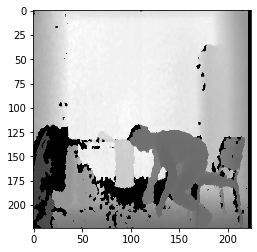

In [57]:
import matplotlib.pyplot as plt

plt.imshow(X_test[15])
y_test[15]

In [58]:
# false - not a fall , True - a fall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1386
        True       0.98      0.98      0.98       591

    accuracy                           0.99      1977
   macro avg       0.98      0.98      0.98      1977
weighted avg       0.99      0.99      0.99      1977



In [59]:
y_test_matrix = []
for i in y_test:
    y_test_matrix.append(i[0])
    
y_pred_matrix = []
y_pred_bool = y_pred > 0.5
for i in y_pred_bool:
    y_pred_matrix.append(i[0])
print(y_test_matrix, y_pred_matrix)

[False, False, False, True, False, False, True, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, True, True, False, True, True, False, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, False, True, False, False, False, True, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, F

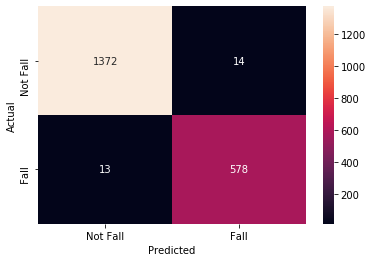

In [60]:
import seaborn as sn
data = {'y_Actual':   y_test_matrix,
        'y_Predicted': y_pred_matrix
        }
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])


sn.heatmap(confusion_matrix,xticklabels=['Not Fall', 'Fall'], yticklabels=[ 'Not Fall', ' Fall'],fmt='g', annot=True)
plt.show()